<a href="https://colab.research.google.com/github/PCeltide/Algorithms-in-Machine-Learning-and-Their-Application/blob/main/Assignments/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The SMO algorithm works in an iterative manner. At first the values for $\beta$ and $b$ are initialized (e.g. as 0 ). In every iteration step we select two indices $i, j \in\{1, \ldots, n\}$ and solve the quadratic optimization problem (SVM) by fixing all $\beta_{k}$ for indices $k \in\{1, \ldots, n\} \backslash\{i, j\}$. Note, that this can be done exactly. To this end, one iterative step for the selected indices $i, j$ can be found in algorithm 2.1.

**Algorithm 2.1 OneStep algorithm to update the coefficients $\beta_i, \beta_j$ and the bias $b$ of $f(\cdot) = \sum_{l=1}^n \beta_l \mathbf{y}_l \langle \cdot, \mathbf{x}_l \rangle_\Omega + b$**

**Input:** Indices $i, j \in \{1, \dots, n\}$.

* $\delta \leftarrow \mathbf{y}_i ((f(\mathbf{x}_j) - \mathbf{y}_j) - (f(\mathbf{x}_i) - \mathbf{y}_i))$
* $s \leftarrow \mathbf{y}_i \cdot \mathbf{y}_j$
* $\chi \leftarrow \langle \mathbf{x}_i, \mathbf{x}_i \rangle_\Omega + \langle \mathbf{x}_j, \mathbf{x}_j \rangle_\Omega - 2 \cdot \langle \mathbf{x}_i, \mathbf{x}_j \rangle_\Omega$
* $\gamma \leftarrow s \beta_i + \beta_j$
* **if** $s = 1$ **then**
    * $L \leftarrow \max(0, \gamma - C)$
    * $H \leftarrow \min(\gamma, C)$
* **else**
    * $L \leftarrow \max(0, -\gamma)$
    * $H \leftarrow \min(C, C - \gamma)$
* **end if**
* **if** $\chi > 0$ **then**
    * $\beta_i \leftarrow \min\left(\max\left(\beta_i + \frac{\delta}{\chi}, L\right), H\right)$
* **else if** $\delta > 0$ **then**
    * $\beta_i \leftarrow L$
* **else**
    * $\beta_i \leftarrow H$
* **end if**
* $\beta_j \leftarrow \gamma - s \beta_i$
* Update function evaluations $f(\mathbf{x}_l), l = 1, \dots, n$
* $b \leftarrow b - \frac{1}{2}(f(\mathbf{x}_i) - \mathbf{y}_i + f(\mathbf{x}_j) - \mathbf{y}_j)$

# **Task 2.1**

Implement the function OneStep from algorithm 2.1, which takes one iterative step of the SMO algorithm for two selected indices $i$ and $j$.

In [2]:
def f(v, x, y, beta, bias, ker):
  if v.ndim == 1:
    v = v.reshape(1,-1) # Makes sure the shapes align to (1, n)
    # print(v.shape)
  beta_y = beta * y
  kernel = ker(v, x.T)
  non_bias = np.dot(kernel, beta_y)
  return non_bias + bias

In [3]:
def OneStep(beta, i, j, x, y, bias, C, ker):

  # Delta calculates the difference between the prediction errors for data points x_j ​and x_i.
  delta = y[i] * ((f(x[j], x, y, beta, bias, ker)-y[j])-(f(x[i], x, y, beta, bias, ker)-y[i]))
  delta = delta.item()
  # s is a checker to see if the x_i and x_j are in the same class
  s = y[i] * y[j]

  # chi relates to the distance between x_i and x_j ​in the feature space; it helps determine the optimal step size for the update.
  chi = np.dot(x[i], x[i])+ np.dot(x[j], x[j]) - 2 * np.dot(x[i], x[j])

  # gamma must remain the same before and after optimization to maintain dot(beta, y)=0
  gamma = s * beta[i] + beta[j]

  # L and H give us the (new) valid range for the beta_i and beta_j
  if s==1:
    L = max(0, gamma - C)
    H = min(gamma, C)
  else :
    L = max(0, -gamma)
    H = min(C, C - gamma)
  # Compute the new beta[i] by adding the unconstrained optimal step delta/chi
  if chi > 0:
    beta[i] = min(max(beta[i] + delta/chi, L), H) # the min/max makes sure it is inside [L,H]
  elif delta > 0:
    beta[i] = L
  else:
    beta[i] = H

  beta[j] = gamma - s* beta[i] # Adjust beta[j]
  # Finally update bias
  bias = bias - (1/2) * ((f(x[j], x, y, beta, bias, ker)-y[j])-(f(x[i], x, y, beta, bias, ker)-y[i]))

# **Task 2.2**

To have a small data set on which we can test our algorithm, we draw $20$ two-dimensional vectors according to an exponential distribution with $\lambda=4$ in each of the coordinate directions, i.e. the $j$-th coordinate of the $i$-th vector is drawn i.i.d. according to $\left[\mathbf{x}_{i}\right]_{j} \sim \exp (4)$ for all $i=1, \ldots, 20$ and $j=1,2$. We assign the label $-1$ to these $\mathbf{x}_{i}$. Then, we draw 20 two-dimensional vectors according to $\exp (0.5)$ in the same way and assign the label 1 to them.

In [4]:
# Draw samples
data_neg = np.random.exponential(scale=0.25, size=(20, 2))
data_pos = np.random.exponential(scale=2, size=(20, 2))

# **Task 2.3**

Implement a function SMO which initializes $\boldsymbol{\beta}=0$ and $b=0$ and - in each iteration step - randomly picks $i, j \in\{1, \ldots, n\}$ such that $i \neq j$ and calls OneStep with indices $i, j$ to perform an optimization.

**(a)** After the last iteration step, we need to compute a final estimate for $b$. To this end, calculate the mean $\boldsymbol{\textrm{me}}$ of $f\left(\mathbf{x}_{k}\right)-\mathbf{y}_{k}$ for all indices $k \in\{1, \ldots, n\}$ for which $0<\beta_{k}<C$. Then, set $b \leftarrow b- \boldsymbol{\textrm{me}}$.

**(b)** Run the SMO function with 10,000 iteration steps to compute a support vector classifier $f$ for the $n=40$ data points from task 2.2. Compute the results for $C=0.01, C=1$ and $C=100$. For each $C$, plot the scattered data and the hyperplane corresponding to $f=0$. Compare your results to the separating hyperplane computed by a linear least squares algorithm.

**(c)** Count the number of support vectors. Mark the corresponding $\mathbf{x}_{k}$ in your scattered data plot.

**(d)** Furthermore, also count the number of margin defining vectors, i.e. the number of indices $k \in\{1, \ldots, n\}$ for which $C>\beta_{k}>0$ and mark the corresponding $\mathbf{x}_{k}$ in the scattered data plot.

What influence does the parameter $C$ have on the number of the support vectors and on the position of the separating hyperplane?

In [5]:
import random as r

In [6]:
def SMO(x, y, C, n, ker=np.dot, iter_steps = 10000):
  n = x.shape[0]
  beta = np.zeros(y.shape[0])
  bias = 0
  for _ in np.arange(iter_steps):
    i_j = r.sample(range(n), 2)
    OneStep(beta, i_j[0], i_j[1], x, y, bias, C, ker)
  in_range = (beta > 0) & (beta < C)
  if np.any(in_range):
    x_in_range = x[in_range, :]
    y_in_range = y[in_range]
    bias = bias - np.mean(f(x_in_range, x, y, beta, bias, ker)-y_in_range)
  else:
    print("bias not updated at the end")
  return beta, bias

In [7]:
def find_sv_margin(beta, C):
  sv = (beta > 0)
  margin = (0 < beta) & (beta < C)
  return sv, margin

In [8]:
def hyper_plotter_spo(X, alpha, points_taken, beta = None, C = None, label=['Class -1', 'Class 1'], grid_points=500, padding=1.0, threshold=0.5): # This is a bit tedious, but using ax and fig allows more control
  # Make a grid for plotting, Add some padding around the data
  fig, ax = plt.subplots()
  # We create boundaries for the plot
  x1_min, x1_max = X[:, 0].min() - padding, X[:, 0].max() + padding
  x2_min, x2_max = X[:, 1].min() - padding, X[:, 1].max() + padding
  # The values we shall "plot"
  x1_vals = np.linspace(x1_min, x1_max, grid_points)
  x2_vals = np.linspace(x2_min, x2_max, grid_points)
  xx1, xx2 = np.meshgrid(x1_vals, x2_vals)
  # Equation to the hyperplane we found above
  equation = alpha[0] + alpha[1] * xx1 + alpha[2] * xx2
  # We color according to hyperplane above
  classification = (equation < threshold).astype(int)
  ax.contourf(xx1, xx2, classification, levels=[-0.5, 0.5, 1.5], colors=['#FFDDDD','#DDDDFF'], alpha=0.7) # Light red/blue using hex, adjust alpha for transparency
  ax.scatter(X[:points_taken, 0], X[:points_taken, 1], color='red', s=50, alpha=0.8, label = label[0])
  ax.scatter(X[points_taken:, 0], X[points_taken:, 1], color='blue', s=50, alpha=0.8, label = label[1])
  if beta is not None and C is not None:
    # Get support and margin vectors
    sv, margin = find_sv_margin(beta, C)
    ax.scatter(X[sv, 0], X[sv, 1], marker='D', color = 'grey', s=50, alpha=0.5, label = 'Support Vectors')
    ax.scatter(X[margin, 0], X[margin, 1], marker='x', color = 'black', s=50, alpha=0.8, label = 'Margin Vectors')
  ax.set_xlim(x1_min, x1_max)
  ax.set_ylim(x2_min, x2_max)
  ax.legend()
  ax.set_xlabel(r'$x_1$')
  ax.set_ylabel(r'$x_2$')
  ax.set_title(r"Hyperplane $H:\alpha_0 + \alpha_1 x_1 + \alpha_2 x_2=0$") # Or a more descriptive title
  plt.show()

In [9]:
# C = 0.01
C_1 = 0.01
data = np.vstack((data_neg, data_pos))
#print(data.shape)
y = np.hstack((np.ones(20), -np.ones(20)))
beta_1, bias_1 = SMO(data, y, C_1, n=40)
print(f"Beta: {beta_1}")
print(f"Bias: {bias_1}")

bias not updated at the end
Beta: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.01
 0.01 0.   0.01 0.01 0.   0.01 0.01 0.01 0.   0.   0.01 0.01 0.   0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
Bias: 0


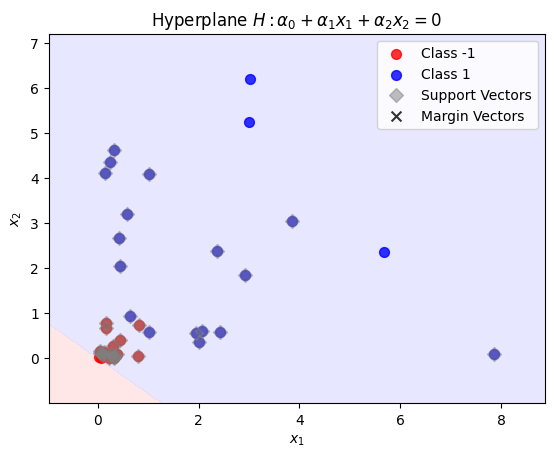

In [10]:
# First we convert back to alpha to plot
beta_y_1 = (beta_1 * y).reshape(-1,1)
alpha_1 = np.sum(beta_y_1 * data, axis = 0)
alpha_1 = np.insert(alpha_1, 0, bias_1)
# Now we can plot
hyper_plotter_spo(data, alpha_1, points_taken = y.shape[0]//2, beta = beta_1, C = C_1, label=['Class -1', 'Class 1'], threshold=0)

In [11]:
# For C=1
C_2 = 1
beta_2, bias_2 = SMO(data, y, C_2, n=40)

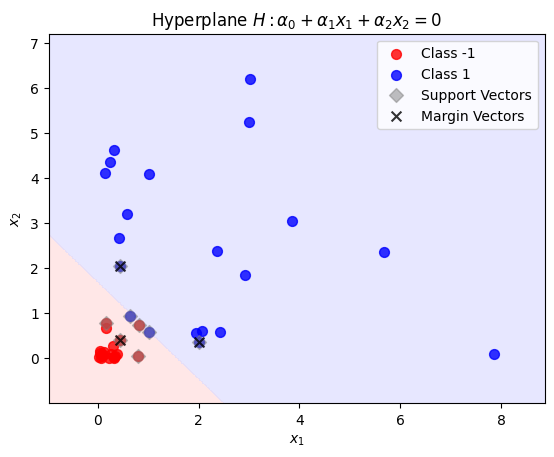

In [12]:
beta_y_2 = (beta_2 * y).reshape(-1,1)
alpha_2 = np.sum(beta_y_2 * data, axis = 0)
alpha_2 = np.insert(alpha_2, 0, bias_2)
# Now we can plot
hyper_plotter_spo(data, alpha_2, points_taken = y.shape[0]//2, beta = beta_2, C = C_2, label=['Class -1', 'Class 1'], threshold=0)

In [13]:
# For C=100
C_3 = 100
beta_3, bias_3 = SMO(data, y, C_3, n=40, iter_steps = 100000)

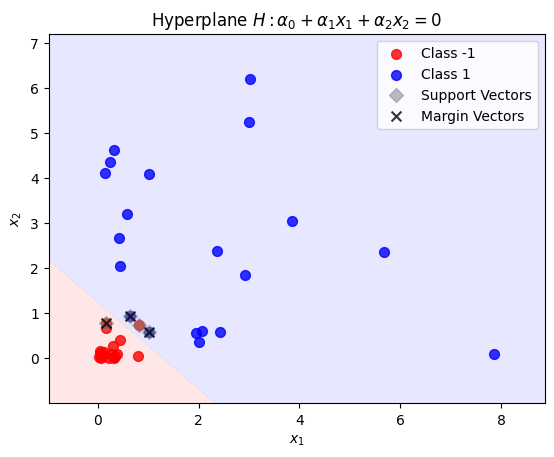

In [14]:
beta_y_3 = (beta_3 * y).reshape(-1,1)
alpha_3 = np.sum(beta_y_3 * data, axis = 0)
alpha_3 = np.insert(alpha_3, 0, bias_3)
# Now we can plot
hyper_plotter_spo(data, alpha_3, points_taken = y.shape[0]//2, beta = beta_3, C = C_3, label=['Class -1', 'Class 1'], threshold=0)

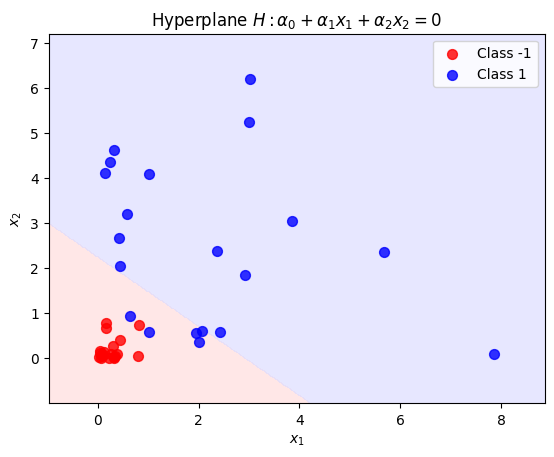

In [15]:
# Least square method
size = y.shape[0]
X_ones = np.hstack((np.ones((size,1)), data))
#print(X.shape)
alpha_4 = np.linalg.solve(X_ones.T @ X_ones, (X_ones.T).dot(y))
hyper_plotter_spo(data ,alpha_4, size//2, label = ['Class -1', 'Class 1'],threshold = 0)

# **Task 2.4.**

Draw 2,000 test data points according to the distributions from task 2.2 (1,000 points for class -1 and 1,000 points for class 1). Evaluate the accuracy (percentage of correctly classified data points) for the LLS and SVM models calculated in task task 2.3.

In [16]:
# Draw samples
test_neg = np.random.exponential(scale=0.25, size=(1000, 2))
test_pos = np.random.exponential(scale=2, size=(1000, 2))
test_points = np.vstack((test_neg, test_pos))
size = test_points.shape[0]

In [17]:
def hyperplane_nd(X_points, alpha):
  return alpha[0] + np.dot(X_points, alpha[1:])

def confusion_matrix_nd(X, alpha, n, total_points):
  # Points belonging to class -1
  X_class_neg_points = X[:n, :]
  # Points belonging to class 1
  X_class_pos_points = X[n:, :]

  hyperplane_output_class_neg = hyperplane_nd(X_class_neg_points, alpha)
  hyperplane_output_class_pos = hyperplane_nd(X_class_pos_points, alpha)

  # True negatives are class -1 points classified as class -1
  true_negatives = np.count_nonzero(hyperplane_output_class_neg >= 0)
  # False positives are class -1 points classified as class 1
  false_positives = n - true_negatives
  # True positives are class 1 points classified as class 1
  true_positives = np.count_nonzero(hyperplane_output_class_pos < 0)
  # False negatives are class 1 points classified as class -1
  false_negatives = total_points - n - true_positives

  return np.array([[true_negatives, false_positives],[false_negatives, true_positives]])

In [18]:
alpha = np.array([alpha_1, alpha_2, alpha_3, alpha_4])
acc = np.zeros(4)
for i in np.arange(alpha.shape[0]):
  conf = confusion_matrix_nd(test_points, alpha[i], size//2, size)
  acc[i] = np.trace(conf)/size
  #print(conf)
print(f"Accuracy of the model for C={C_1} is {acc[0]*100}%")
print(f"Accuracy of the model for C={C_2} is {acc[1]*100}%")
print(f"Accuracy of the model for C={C_3} is {acc[2]*100}%")
print(f"Accuracy of the least square model is {acc[3]*100}%")

Accuracy of the model for C=0.01 is 50.0%
Accuracy of the model for C=1 is 89.45%
Accuracy of the model for C=100 is 90.5%
Accuracy of the least square model is 81.75%


We observe that $C=0.01$ underfits, $C=100$ overfits (yet nearly equals the least-square model); $C=1$ gives a (significantly) better model.

# **Task 2.5.**

Repeat task 2.3 and task 2.4 but instead of drawing the indices $i, j$ for each SMO-step randomly, write an outer loop which iterates over all $i \in\{1, \ldots, n\}$ and check if $\mathrm{KKT}_{i}>0$. If this is the case, randomly pick a $j \neq i$ for which $0<\beta_{j}<C$. If no such $j$ exists, randomly pick $j \in\{1, \ldots, n\} \backslash\{i\}$. Subsequently, run the OneStep function for the pair $(i, j)$. If $\mathrm{KKT}_{i}=0$ for each $i$ or if the maximum number of OneStep calls $(10,000)$ is reached, the algorithm terminates. Compare the results achieved with this heuristic with the results achieved by randomly picking $i$ and $j$. How do their runtimes compare?

The Karush-Kuhn-Tucker conditions of the dual minimization problem is given by:
$$
\begin{equation*}
\mathrm{KKT}_{i}:=\left(C-\beta_{i}\right) \max \left(0,1-y_{i} f\left(\mathbf{x}_{i}\right)\right)+\beta_{i} \max \left(0, y_{i} f\left(\mathbf{x}_{i}\right)-1\right) .
\end{equation*}
$$

In [19]:
def KKT_i(i, C, beta, y, x, bias, ker):
  return (C-beta[i]) * max(0, 1-y[i]*f(x[i], x, y, beta, bias, ker))+ beta[i] * max(0, y[i]*f(x[i], x, y, beta, bias, ker)-1)

In [20]:
def SMO_KKT(x, y, C, n, ker = np.dot, iter_steps = 10000):
  n = x.shape[0]
  beta = np.zeros(y.shape[0])
  bias = 0
  _ , margin = find_sv_margin(beta, C)
  margin = np.where(margin)[0]
  steps = 0
  while steps < iter_steps:
    i = 0
    while i < n:
      KKT = KKT_i(i, C, beta, y, x, bias, ker)
      if KKT == 0:
        i += 1
        continue
      margin_idx = margin[margin != i]
      if margin_idx.size == 0:
        ranges = np.arange(n)
        j = np.random.choice(ranges[ranges != i], replace=True)
      else:
        j = np.random.choice(margin_idx, replace=True)
      OneStep(beta, i, j, x, y, bias, C, ker)
      steps += 1
      if steps >= iter_steps:
        break
      i = 0
    break
  in_range = (beta > 0) & (beta < C)
  if np.any(in_range):
    x_in_range = x[in_range, :]
    y_in_range = y[in_range]
    bias = bias - np.mean(f(x_in_range, x, y, beta, bias, ker)-y_in_range)
  else:
    print("bias not updated at the end")
  return beta, bias

In [21]:
# For C=1, Simple Random Choice
C_1 = 1
beta_1, bias_1 = SMO(data, y, C_1, n=40)
beta_y_1 = (beta_2 * y).reshape(-1,1)
alpha_1 = np.sum(beta_y_1 * data, axis = 0)
alpha_1 = np.insert(alpha_1, 0, bias_1)

In [22]:
%%timeit
beta_1, bias_1 = SMO(data, y, C_1, n=40)

746 ms ± 195 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


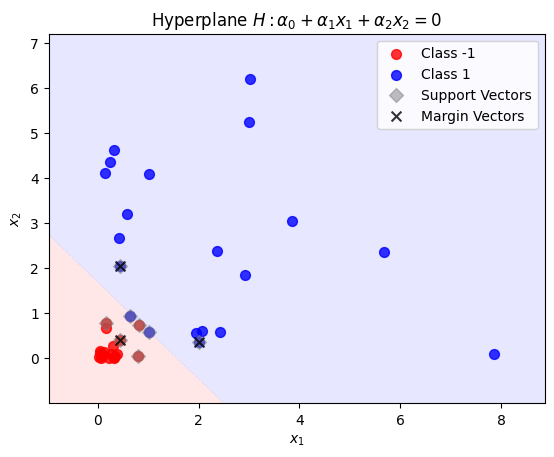

In [23]:
# Now we can plot
hyper_plotter_spo(data, alpha_1, points_taken = y.shape[0]//2, beta = beta_1, C = C_1, label=['Class -1', 'Class 1'], threshold=0)

In [24]:
# For C=1, with KKT
C_2 = 1
beta_2, bias_2 = SMO_KKT(data, y, C_2, n=40)
beta_y_2 = (beta_2 * y).reshape(-1,1)
alpha_2 = np.sum(beta_y_2 * data, axis = 0)
alpha_2 = np.insert(alpha_2, 0, bias_2)

In [25]:
%%timeit
beta_2, bias_2 = SMO_KKT(data, y, C_2, n=40)

1.63 s ± 660 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


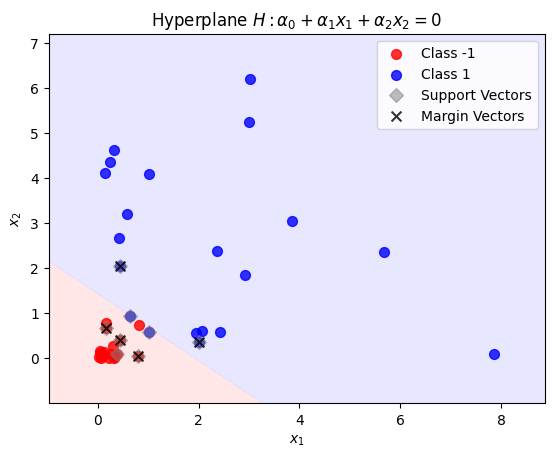

In [26]:
# Now we can plot
hyper_plotter_spo(data, alpha_2, points_taken = y.shape[0]//2, beta = beta_2, C = C_2, label=['Class -1', 'Class 1'], threshold=0)

In [27]:
# Draw samples
test_neg = np.random.exponential(scale=0.25, size=(1000, 2))
test_pos = np.random.exponential(scale=2, size=(1000, 2))
test_points = np.vstack((test_neg, test_pos))
size = test_points.shape[0]
alpha = np.array([alpha_1, alpha_2])
acc = np.zeros(2)
for i in np.arange(alpha.shape[0]):
  conf = confusion_matrix_nd(test_points, alpha[i], size//2, size)
  acc[i] = np.trace(conf)/size
  #print(conf)
print(f"Accuracy of the non_KKT based model for C={C_1} is {acc[0]*100}%")
print(f"Accuracy of the KKT based model for C={C_2} is {acc[1]*100}%")

Accuracy of the non_KKT based model for C=1 is 89.7%
Accuracy of the KKT based model for C=1 is 89.55%


In [28]:
# For C=1, Simple Random Choice
C_1 = 100
beta_1, bias_1 = SMO(data, y, C_1, n=40)
beta_y_1 = (beta_2 * y).reshape(-1,1)
alpha_1 = np.sum(beta_y_1 * data, axis = 0)
alpha_1 = np.insert(alpha_1, 0, bias_1)

In [29]:
%%timeit
beta_1, bias_1 = SMO(data, y, C_1, n=40)

430 ms ± 8.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


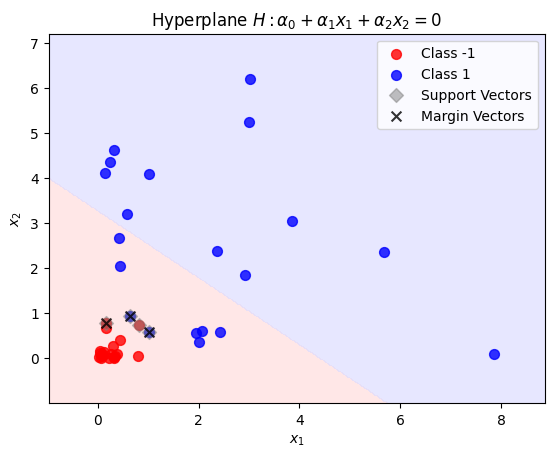

In [30]:
# Now we can plot
hyper_plotter_spo(data, alpha_1, points_taken = y.shape[0]//2, beta = beta_1, C = C_1, label=['Class -1', 'Class 1'], threshold=0)

In [31]:
# For C=1, with KKT
C_2 = 100
beta_2, bias_2 = SMO_KKT(data, y, C_2, n=40)
beta_y_2 = (beta_2 * y).reshape(-1,1)
alpha_2 = np.sum(beta_y_2 * data, axis = 0)
alpha_2 = np.insert(alpha_2, 0, bias_2)

In [32]:
%%timeit
beta_2, bias_2 = SMO_KKT(data, y, C_2, n=40)

1.43 s ± 733 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


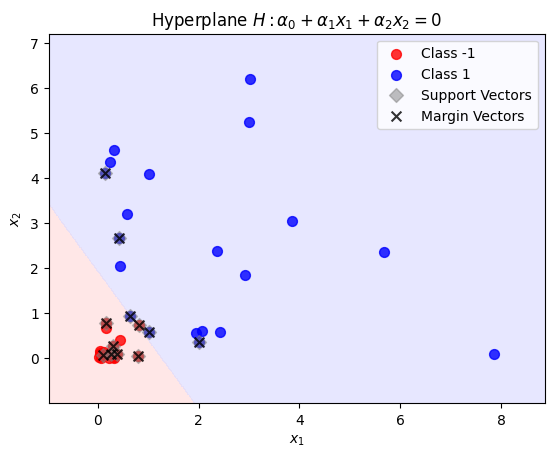

In [33]:
# Now we can plot
hyper_plotter_spo(data, alpha_2, points_taken = y.shape[0]//2, beta = beta_2, C = C_2, label=['Class -1', 'Class 1'], threshold=0)

In [34]:
# Draw samples
test_neg = np.random.exponential(scale=0.25, size=(1000, 2))
test_pos = np.random.exponential(scale=2, size=(1000, 2))
test_points = np.vstack((test_neg, test_pos))
size = test_points.shape[0]
alpha = np.array([alpha_1, alpha_2])
acc = np.zeros(2)
for i in np.arange(alpha.shape[0]):
  conf = confusion_matrix_nd(test_points, alpha[i], size//2, size)
  acc[i] = np.trace(conf)/size
  #print(conf)
print(f"Accuracy of the non_KKT based model for C={C_1} is {acc[0]*100}%")
print(f"Accuracy of the KKT based model for C={C_2} is {acc[1]*100}%")

Accuracy of the non_KKT based model for C=100 is 71.6%
Accuracy of the KKT based model for C=100 is 90.5%


# **Task 2.6.**

Generate 50 uniformly distributed i.i.d. points which lie in $\{\mathbf{t} \in$ $\left.\mathbb{R}^{2} \mid\|\mathbf{t}\|_{2}<1\right\}$ (e.g. by drawing uniformly distributed points in $(-1,1)^{2}$ until 50 of them are within the unit sphere) and label them by -1 . Now generate 50 data points, which are uniformly distributed in $\left\{\mathbf{t} \in \mathbb{R}^{2} \mid 1<\|\mathbf{t}\|_{2}<2\right\}$ and label them by 1.


In [35]:
# We can be more efficient by using the polar form
theta = np.random.uniform(0, 2*np.pi, 100)
r_1_sq = np.random.uniform(0, 1, 50)
r_1 = np.sqrt(r_1_sq) # This is really cute! We want r^2 to be uniformly distributed to make the point selection in the cicle/annulus uniform!
r_2_sq = np.random.uniform(1, 2, 50)
r_2 = np.sqrt(r_2_sq)

uni_neg = np.column_stack((r_1 * np.cos(theta[:50]), r_1 * np.sin(theta[:50])))
uni_pos = np.column_stack((r_2 * np.cos(theta[50:]), r_2 * np.sin(theta[50:])))
data = np.vstack((uni_neg, uni_pos))
y = np.hstack(((-1)*np.ones(50), np.ones(50)))
#print(data, data.shape)

**(a)** Fit a linear SVM for $C=10$ to the data and plot the scattered data as well as the separating hyperplane.

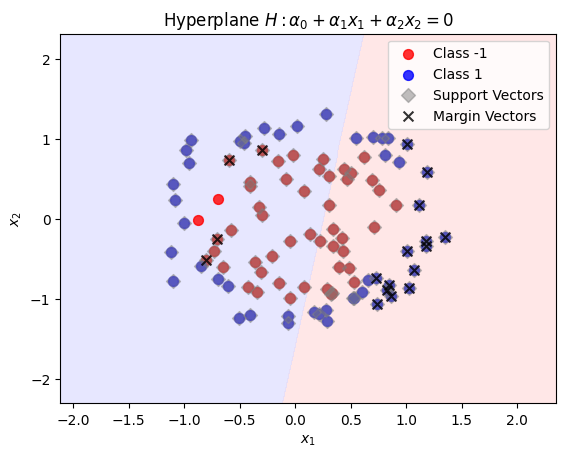

In [36]:
C = 10
beta, bias = SMO_KKT(data, y, C, n=40)
beta_y = (beta * y).reshape(-1,1)
alpha = np.sum(beta_y * data, axis = 0)
alpha = np.insert(alpha, 0, bias)
hyper_plotter_spo(data, alpha, points_taken = y.shape[0]//2, beta = beta, C = C, label=['Class -1', 'Class 1'], threshold=0)

**(b)** Transform the data by the feature map $\phi: \mathbb{R}^{2} \rightarrow \mathbb{R}^{3}$ defined by
$$
\phi(\mathbf{t}):=\left(t_{1}, t_{2}, t_{1}^{2}+t_{2}^{2}\right)
$$

Fit an SVM for C $=10$ to the transformed data. Plot the scattered data and the nonlinear separation curve in a $2 d$ plot (i.e. in the same way as in (a)). What does the feature map do and why does it work so well?

In [37]:
def feature_uni(t):
  t_0 = t[: , 0]
  t_1 = t[: , 1]
  t_transform = (t_0 **2 + t_1 ** 2).reshape(-1, 1)
  #print(t_transform.shape)
  return np.hstack((t,t_transform))

In [38]:
# Temporary defintion of hyperplotter

def hyper_plotter_spo_temp(X, alpha, points_taken, beta = None, C = None, label=['Class -1', 'Class 1'], grid_points=500, padding=1.0, threshold=0.5): # This is a bit tedious, but using ax and fig allows more control
  # Make a grid for plotting, Add some padding around the data
  fig, ax = plt.subplots()
  # We create boundaries for the plot
  x1_min, x1_max = X[:, 0].min() - padding, X[:, 0].max() + padding
  x2_min, x2_max = X[:, 1].min() - padding, X[:, 1].max() + padding
  # The values we shall "plot"
  x1_vals = np.linspace(x1_min, x1_max, grid_points)
  x2_vals = np.linspace(x2_min, x2_max, grid_points)
  xx1, xx2 = np.meshgrid(x1_vals, x2_vals)
  # Equation to the hyperplane we found above
  equation = alpha[0] + alpha[1] * xx1 + alpha[2] * xx2 + alpha[3] * (xx1**2 + xx2**2)
  # We color according to hyperplane above
  classification = (equation > threshold).astype(int)
  ax.contourf(xx1, xx2, classification, levels=[-0.5, 0.5, 1.5], colors=['#FFDDDD','#DDDDFF'], alpha=0.7) # Light red/blue using hex, adjust alpha for transparency
  ax.scatter(X[:points_taken, 0], X[:points_taken, 1], color='red', s=50, alpha=0.8, label = label[0])
  ax.scatter(X[points_taken:, 0], X[points_taken:, 1], color='blue', s=50, alpha=0.8, label = label[1])
  if beta is not None and C is not None:
    # Get support and margin vectors
    sv, margin = find_sv_margin(beta, C)
    ax.scatter(X[sv, 0], X[sv, 1], marker='D', color = 'grey', s=50, alpha=0.5, label = 'Support Vectors')
    ax.scatter(X[margin, 0], X[margin, 1], marker='x', color = 'black', s=50, alpha=0.8, label = 'Margin Vectors')
  ax.set_xlim(x1_min, x1_max)
  ax.set_ylim(x2_min, x2_max)
  ax.legend()
  ax.set_xlabel(r'$x_1$')
  ax.set_ylabel(r'$x_2$')
  ax.set_title(r"Hyperplane $H:\alpha_0 + \alpha_1 x_1 + \alpha_2 x_2 + \alpha_3 (x_1^2+x_2^2)=0$") # Or a more descriptive title
  plt.show()

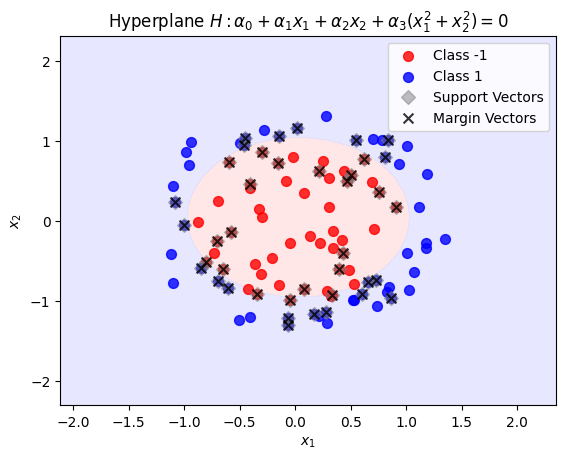

In [39]:
# Transform Data
data_feature = feature_uni(data)

C = 10
beta_feature, bias_feature = SMO_KKT(data_feature, y, C, n=40)
beta_y_feature = (beta_feature * y).reshape(-1,1)
alpha_feature = np.sum(beta_y_feature * data_feature, axis = 0)
alpha_feature = np.insert(alpha_feature, 0, bias_feature)
hyper_plotter_spo_temp(data_feature, alpha_feature, points_taken = y.shape[0]//2, beta = beta_feature, C = C, label=['Class -1', 'Class 1'], threshold=0)

One of the most important theorems for kernel learning algorithms such as the nonlinear SVM is **Mercer's theorem**: It tells us that for each continuous, symmetric and non-negative definite kernel function $K$ there exists a corresponding feature map $\phi$.

The Gaussian Kernel is given by
$$
K_{\sigma}(\mathbf{t}, \mathbf{x}):=\exp \left(-\frac{\|\mathbf{t}-\mathbf{x}\|_{\mathbb{R}^{d}}^{2}}{2 \sigma^{2}}\right)
$$

# **Task 2.7.**
Change your SMO code and your function evaluation of $f$ from (2.2) such that it allows to use a kernel function instead of the scalar product of the input data, i.e. substitute all scalar products by the evaluation of the kernel function. Perform a SVM classification $(C=10)$ with Gaussian kernel ( $\sigma=1$ ) for the data from task 2.6. Plot the scattered data and the nonlinear separation curve in a $2 d$ plot.

In [40]:
from scipy.spatial.distance import cdist

In [41]:
def gaussian_ker(t, X, sigma=1):
  if t.ndim == 1:
    t = t.reshape(1,-1) # Makes sure the shapes align to (1, n)
  dist_mat = cdist(t, X.T, metric="sqeuclidean")
  return np.exp(-dist_mat/(2*sigma**2))

In [42]:
def hyper_plotter_spo_gauss_ker(X, alpha, points_taken, bias=None, beta = None, C = None, label=['Class -1', 'Class 1'], grid_points=500, padding=1.0, threshold=0):
  # Make a grid for plotting, Add some padding around the data
  fig, ax = plt.subplots()
  # We create boundaries for the plot
  x1_min, x1_max = X[:, 0].min() - padding, X[:, 0].max() + padding
  x2_min, x2_max = X[:, 1].min() - padding, X[:, 1].max() + padding
  # The values we shall "plot"
  x1_vals = np.linspace(x1_min, x1_max, grid_points)
  x2_vals = np.linspace(x2_min, x2_max, grid_points)
  xx1, xx2 = np.meshgrid(x1_vals, x2_vals)

  # Prepare grid points in the format your gaussian_ker and decision function expect
  # .ravel() "flattens" the multidimensional numpy array
  # np.c_ stacks the columns inputted
  grid_points_flat = np.c_[xx1.ravel(), xx2.ravel()] # grid_points_flat will be an array of shape (grid_points*grid_points, 2)

  # Initialize decision values for all grid points
  decision_values_flat = np.zeros(grid_points_flat.shape[0])

  # Find indices of support vectors and margin
  sv, margin = find_sv_margin(beta, C)
  sv_coords = X[sv,:]
  sv_beta = beta[sv]
  sv_y = y[sv]
  beta_y_sv = sv_beta * sv_y

  # Dot product sums over support vectors for each grid point
  kernel_matrix = gaussian_ker(grid_points_flat, sv_coords.T)
  decision_values_flat = np.dot(kernel_matrix, beta_y_sv) + bias

  # Reshape the flat decision values back to the grid shape
  Z = decision_values_flat.reshape(xx1.shape)

  # Your 'equation' variable is now 'Z'
  classification = (Z < 0).astype(int) # Or Z > 0, depending on class configuration
  # And then use Z for contourf if you want filled regions based on the sign of Z
  ax.contourf(xx1, xx2, Z, levels=[-np.inf, 0, np.inf], colors=['#FFDDDD','#DDDDFF'], alpha=0.7)
  ax.scatter(X[:points_taken, 0], X[:points_taken, 1], color='red', s=50, alpha=0.8, label = label[0])
  ax.scatter(X[points_taken:, 0], X[points_taken:, 1], color='blue', s=50, alpha=0.8, label = label[1])
  if beta is not None and C is not None:
    # Get support and margin vectors
    ax.scatter(X[sv, 0], X[sv, 1], marker='D', color = 'grey', s=50, alpha=0.5, label = 'Support Vectors')
    ax.scatter(X[margin, 0], X[margin, 1], marker='x', color = 'black', s=50, alpha=0.8, label = 'Margin Vectors')
  ax.set_xlim(x1_min, x1_max)
  ax.set_ylim(x2_min, x2_max)
  ax.legend()
  ax.set_xlabel(r'$x_1$')
  ax.set_ylabel(r'$x_2$')
  ax.set_title(r"Hyperplane given by Gaussian Kernel") # Or a more descriptive title
  plt.show()

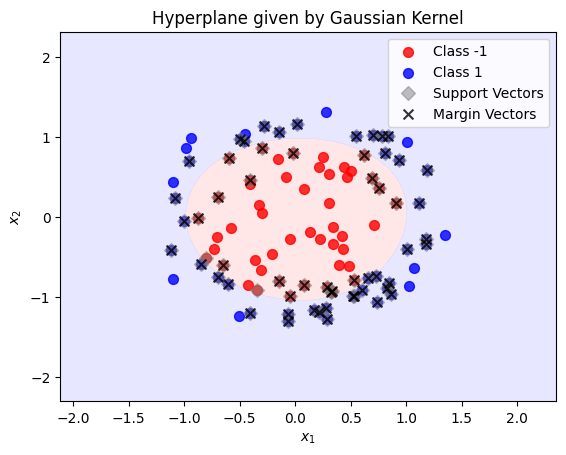

In [43]:
C = 10
beta, bias = SMO_KKT(data, y, C, ker = gaussian_ker, n=40)
beta_y = (beta * y).reshape(-1,1)
alpha = np.sum(beta_y * data, axis = 0)
alpha = np.insert(alpha, 0, bias)
hyper_plotter_spo_gauss_ker(data, alpha, points_taken = y.shape[0]//2, bias=bias, beta = beta, C = C, label=['Class -1', 'Class 1'])

#**Task 2.8.**

Make yourself familiar with the SVC function in scikit-learn, which implements a support vector classifier.

In [44]:
# Load the MNIST data

import tensorflow as tf

try:
    # Load data directly using TensorFlow Keras API
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Normalize the images to the range [0, 1]
    X_train = X_train.astype("float32") / 255.0
    X_test = X_test.astype("float32") / 255.0

    # Keras load_data() returns images as (num_samples, 28, 28)
    # and labels as (num_samples,) which is fine for most uses.

    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)

    # Example of how to view an image (optional)
    # import matplotlib.pyplot as plt
    # plt.imshow(X_train[0], cmap='gray')
    # plt.title(f"Label: {y_train[0]}")
    # plt.show()

except Exception as e:
    print(f"An error occurred with TensorFlow/Keras: {e}")
    print("Please ensure you have TensorFlow installed (e.g., pip install tensorflow)")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


(a) Choose a random subset of size 500 from the MNIST training data and use this as your new training data set for crossvalidation. Perform a 5-fold crossvalidation SVM to determine the optimal parameters among
$C\in \{1,10,100\}$ and $\gamma = \frac{1}{2\sigma^2}\in\{0.1,0.01,0.001\}$.

In [86]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [87]:
# random n points from our data
n = 500
random_indices = np.random.choice(np.arange(X_train.shape[0]), size=n, replace=False)
random_data = X_train[random_indices,:,:]

# Before we go ahead, we have to flatten out our data so that it fits
# We do this my doing (n_samples, height, width) ---> (n_samples, height*width)
# This allows to use the grid SVC function from sk.learn.svm (it expects a 2-d array)
random_data = random_data.reshape(random_data.shape[0], random_data.shape[1]*random_data.shape[2])

random_data_label = y_train[random_indices]
#print(random_data.shape)
#print(random_data_label.shape)

In [88]:
param_grid = {
              'C' : [1, 10, 100],
              'gamma' : [0.1,0.01,0.001]
             }
svm_estimator = SVC() # Default Kernel is 'rbf' or Radial Basis Function (eff. Gaussian Kernel)
grid_search = GridSearchCV(estimator=svm_estimator,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy', # Or another metric if you prefer
                           verbose=1)
grid_search.fit(random_data, random_data_label)
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found: {'C': 10, 'gamma': 0.001}
Best cross-validation score: 0.866


(b) Use the determined optimal parameters to learn a support vector classifier on a random 2,000 point subset of the MNIST training data and
evaluate the confusion matrix and the accuracy on the whole MNIST test data set.

In [99]:
n = 2000

all_possible_indices = np.arange(X_train.shape[0])
available_choices_set = set(all_possible_indices) - set(random_indices)
available_choices_array = np.array(list(available_choices_set))

# Just a small way to make sure that we exclude the 500 points that we selected earlier
# While not necessary, we do have the luxary of data to see how well the model extrapoltes
random_train_indices = np.random.choice(available_choices_array, size=n, replace=False)
random_train_data = X_train[random_train_indices,:,:]
random_train_data = random_train_data.reshape(random_train_data.shape[0], random_train_data.shape[1]*random_train_data.shape[2])
random_train_data_label = y_train[random_train_indices]

In [94]:
C, gamma = grid_search.best_params_['C'], grid_search.best_params_['gamma']
best_hyper = SVC(C=C, gamma=gamma)
best_hyper.fit(random_train_data, random_train_data_label)

SVC(C=10, gamma=0.001)

In [95]:
# Have to convert X_test data to 2d too!
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
y_pred = best_hyper.predict(X_test_reshaped)

In [96]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt # For visualizing confusion matrix
import seaborn as sns # For a nicer looking confusion matrix visualization

In [97]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy on Test Set: {accuracy:.4f} (or {accuracy*100:.2f}%)")


Model Accuracy on Test Set: 0.9199 (or 91.99%)



Confusion Matrix:


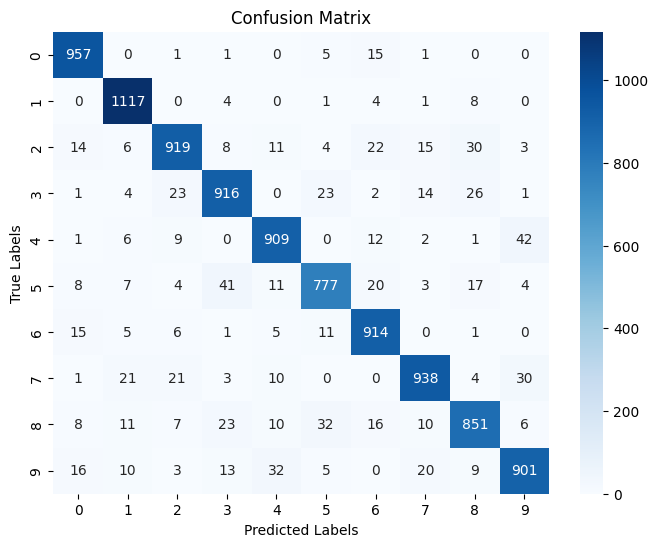


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.94      0.98      0.96      1135
           2       0.93      0.89      0.91      1032
           3       0.91      0.91      0.91      1010
           4       0.92      0.93      0.92       982
           5       0.91      0.87      0.89       892
           6       0.91      0.95      0.93       958
           7       0.93      0.91      0.92      1028
           8       0.90      0.87      0.89       974
           9       0.91      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [98]:
print("\nConfusion Matrix:")
# Use model.classes_ to ensure the labels in the matrix are in a known order
cm = confusion_matrix(y_test, y_pred, labels=best_hyper.classes_)

# For better readability, you can visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# 6. Generate Classification Report
print("\nClassification Report:")
report = classification_report(y_test, y_pred, labels=best_hyper.classes_)
print(report)

Is our approach of picking a different training set in step (b) - and learning with the optimal parameters from (a) - valid? Are there potential pitfalls?

The validity of our method relies on the ability to extrapolate the observations we saw on the 500-point subset to the larger MNIST training data, such that the hyperparameters found to be optimal on this subset are very close to optimal for a larger subset and ideally for the entire training dataset.

Though, something to be checked could be that the hyperparameters that are optimal for 500 data points might not be optimal for 2000 data points.

Notabaly though, we haven't used all the training data to optimize our hyperparameters nor in tuning the model. Tuning to the larger data might lead to a better model.